In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import calendar
import matplotlib.pyplot as plt
import yfinance as yf
import re
from nltk.tokenize import word_tokenize

from collections import Counter
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

sns.set_theme(style="whitegrid")

/Users/kellygong/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Exploratory Data Analysis

### News Datasets

The three news datasets are obtained through [Kaggle](https://www.kaggle.com/datasets/notlucasp/financial-news-headlines/data). The author mentioned these data are scraped from CNBC, the Guardian, and Reuters official websites, the headlines in these datasets reflects the overview of the U.S. economy and stock market every day for the past year to 2 years.

The Timeframes of data:

  - Data scraped from CNBC contains the headlines, last updated date, and the preview text of articles from the end of `December 2017` to `July 19th, 2020`.
  - Data scraped from the Guardian Business contains the headlines and last updated date of articles from the end of `December 2017` to `July 19th, 2020` since the Guardian Business does not offer preview text.
  - Data scraped from Reuters contains the headlines, last updated date, and the preview text of articles from the end of `March 2018` to `July 19th, 2020`.

In [2]:
cnbc_data = pd.read_csv('dataset/cnbc_headlines.csv')

# There is ,, empty lines in CNBC, drop them
cnbc_data.dropna(subset=['Time'],inplace=True)

guardian_data = pd.read_csv('dataset/guardian_headlines.csv')
reuters_data = pd.read_csv('dataset/reuters_headlines.csv')

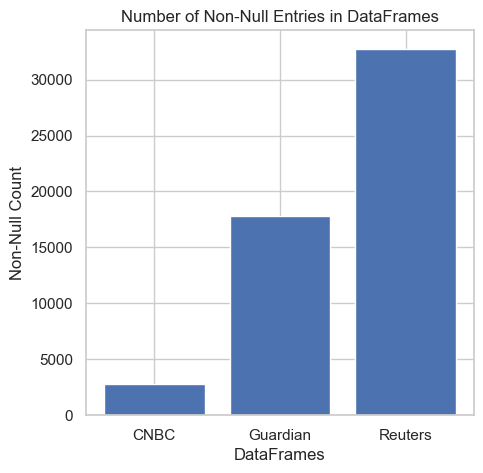

In [3]:
dfs = [cnbc_data, guardian_data, reuters_data]
df_names = ['CNBC', 'Guardian', 'Reuters']

non_null_counts = [df.dropna().shape[0] for df in dfs]

plt.figure(figsize=(5, 5))
plt.bar(df_names, non_null_counts)
plt.title("Number of Non-Null Entries in DataFrames")
plt.xlabel("DataFrames")
plt.ylabel("Non-Null Count")
plt.show()

We can see here that all of the news datasets have varying numbers of data points ranging from 2800 to 32700. This will not be a problem for us since our question focuses on the impact of news headlines in general on the S&P 500, so all of this data will be combined in to a larger dataset ordered by the date of the headline. We can also see there is null data within the CNBC dataset which will be removed. 

#### Headline Length


/Users/kellygong/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kellygong/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kellygong/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


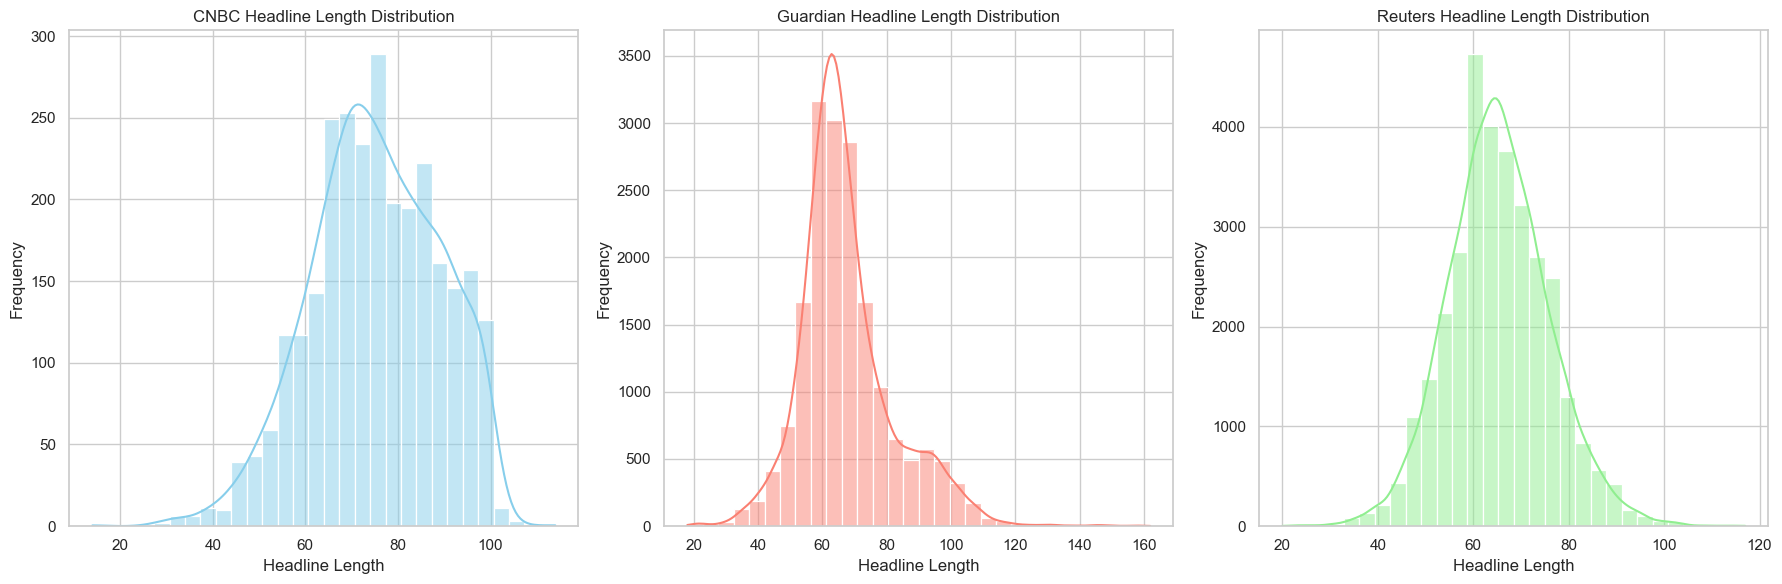

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# CNBC dataset
sns.histplot(cnbc_data['Headlines'].fillna("").apply(len), bins=30, kde=True, ax=ax[0], color="skyblue")
ax[0].set_title("CNBC Headline Length Distribution")
ax[0].set_xlabel("Headline Length")
ax[0].set_ylabel("Frequency")

# Guardian dataset
sns.histplot(guardian_data['Headlines'].fillna("").apply(len), bins=30, kde=True, ax=ax[1], color="salmon")
ax[1].set_title("Guardian Headline Length Distribution")
ax[1].set_xlabel("Headline Length")
ax[1].set_ylabel("Frequency")

# Reuters dataset
sns.histplot(reuters_data['Headlines'].fillna("").apply(len), bins=30, kde=True, ax=ax[2], color="lightgreen")
ax[2].set_title("Reuters Headline Length Distribution")
ax[2].set_xlabel("Headline Length")
ax[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


These histograms display the number of headlines given a specific length. Disregarding the bar at length of 0 in the CNBC graph due to the null data, headlines from all three stations seem to center around 60-70 words with the max being ~100 for CNBC and Reuters, and ~120 for the Guardian.

#### Headline Distribution

To find out the distribution of headlines throughout the time frame, we generated a graph with headlines colored differently in each month of the year.

In [5]:
# Extra cleaning for CNBC
cnbc_data['Time'] = (
    cnbc_data['Time']
    .str.replace(r"ET", "", regex=True)  
    .str.strip() 
    .str.replace(r"\s+", " ", regex=True)
)

In [6]:
cnbc_data['Time'] = pd.to_datetime(
    cnbc_data['Time'], format="mixed", errors='coerce'
)

# For GUARDIAN
guardian_data['Time'] = pd.to_datetime(
    guardian_data['Time'], format='%d-%b-%y', errors='coerce'
)

# For REUTERS
reuters_data['Time'] = pd.to_datetime(
    reuters_data['Time'], format='%b %d %Y', errors='coerce'
)

# Adding additional columns for time analysis
for df in [cnbc_data, guardian_data, reuters_data]:
    # Extract date parts for time-based analysis
    df['Year'] = df['Time'].dt.year
    df['Month'] = df['Time'].dt.month

# Frequency of headlines by year and month for each dataset
cnbc_yearly_counts = cnbc_data.groupby(['Year', 'Month']).size().unstack(fill_value=0)
guardian_yearly_counts = guardian_data.groupby(['Year', 'Month']).size().unstack(fill_value=0)
reuters_yearly_counts = reuters_data.groupby(['Year', 'Month']).size().unstack(fill_value=0)

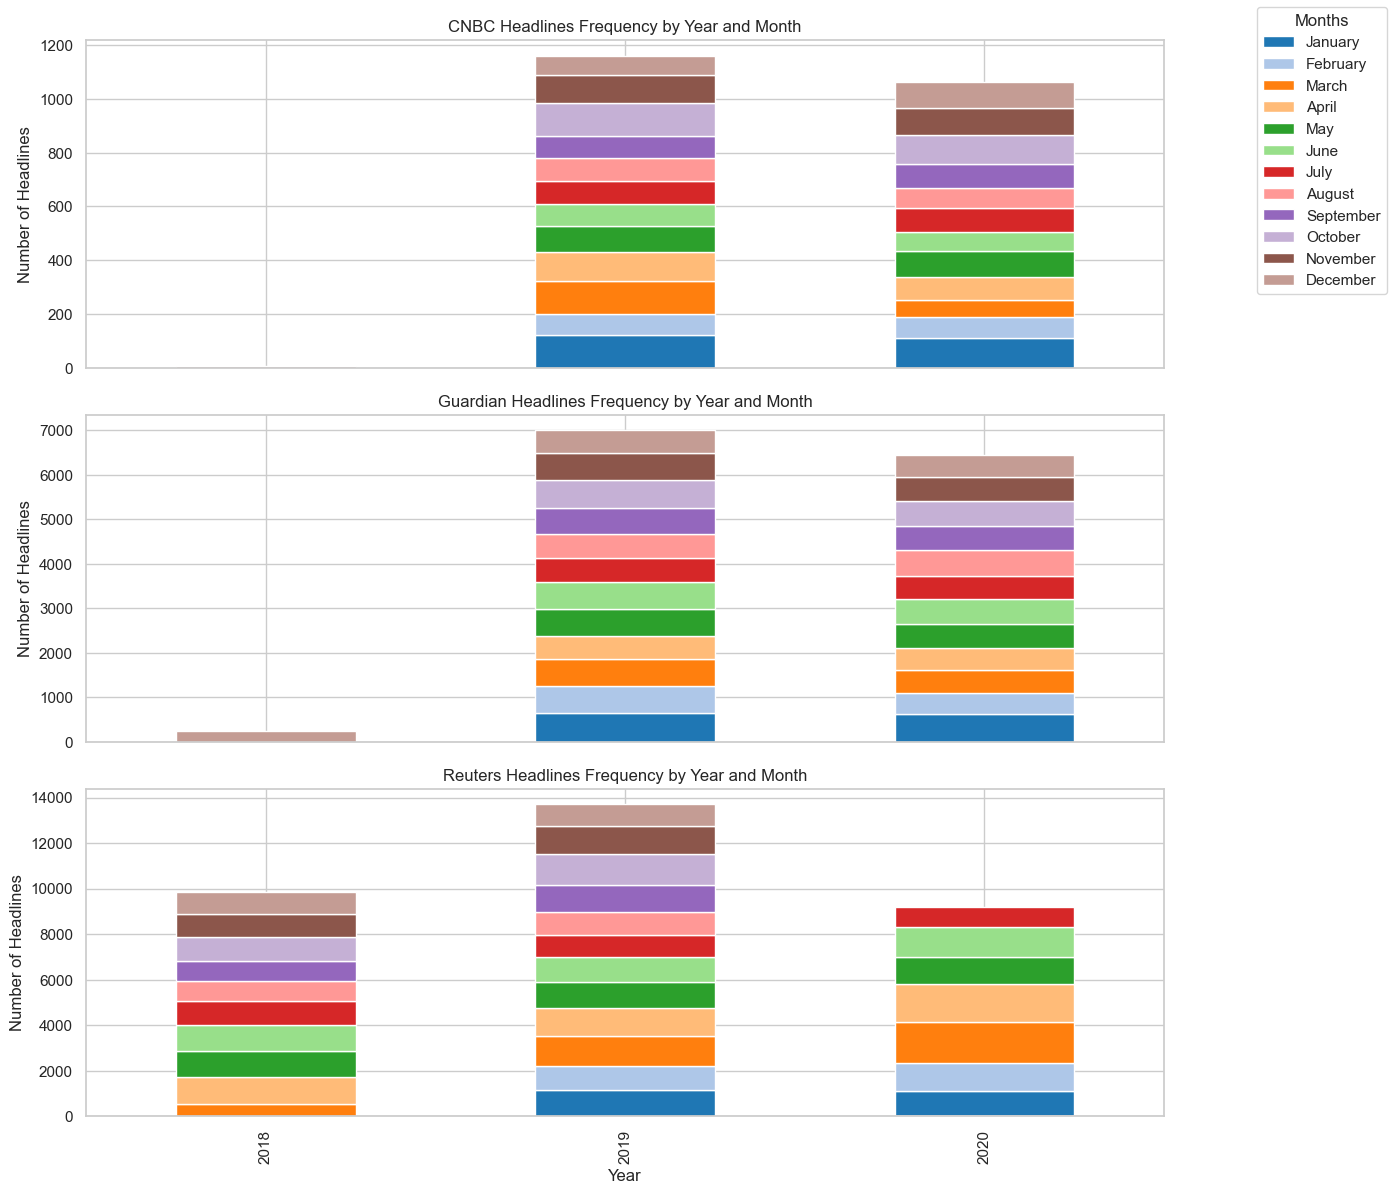

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Set a colormap to represent months consistently
month_colors = plt.colormaps["tab20"]

# CNBC dataset with month colors
cnbc_yearly_counts.plot(kind="bar", stacked=True, ax=ax[0], color=[month_colors(i) for i in range(12)], legend=False)
ax[0].set_title("CNBC Headlines Frequency by Year and Month")
ax[0].set_ylabel("Number of Headlines")

# Guardian dataset with month colors
guardian_yearly_counts.plot(kind="bar", stacked=True, ax=ax[1], color=[month_colors(i) for i in range(12)], legend=False)
ax[1].set_title("Guardian Headlines Frequency by Year and Month")
ax[1].set_ylabel("Number of Headlines")

# Reuters dataset with month colors
reuters_yearly_counts.plot(kind="bar", stacked=True, ax=ax[2], color=[month_colors(i) for i in range(12)], legend=False)
ax[2].set_title("Reuters Headlines Frequency by Year and Month")
ax[2].set_ylabel("Number of Headlines")
ax[2].set_xlabel("Year")

# Adding a single legend for the months
month_names = [calendar.month_name[i] for i in range(1, 13)]
fig.legend(month_names, loc="upper right", title="Months")
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to fit the legend
plt.show()

These graphs depict the number of headlines per month per year. With this, we can see that the earlier months of the year seem to have a higher concentration of headlines. 

In [8]:
for df in [cnbc_data, guardian_data, reuters_data]:
    df.drop(columns=['Year','Month'],inplace=True)

#### Word Frequency

A short analysis on word frequency. We used the stopword dictionary in `nltk` to help filtering out words like `a` and `the`.

In [9]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kellygong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/Users/kellygong/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/Users/kellygong/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


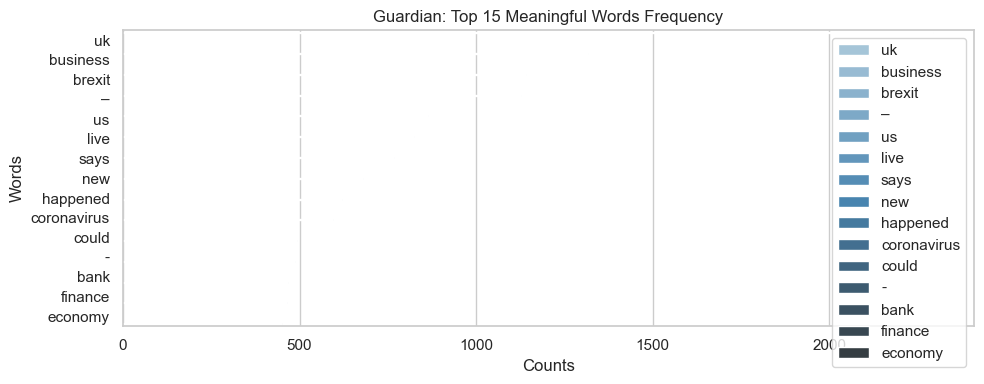

/Users/kellygong/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/Users/kellygong/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


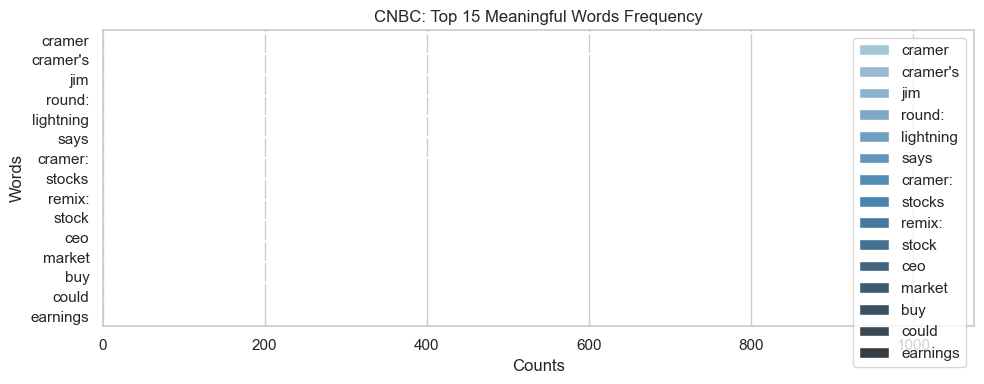

/Users/kellygong/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/Users/kellygong/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


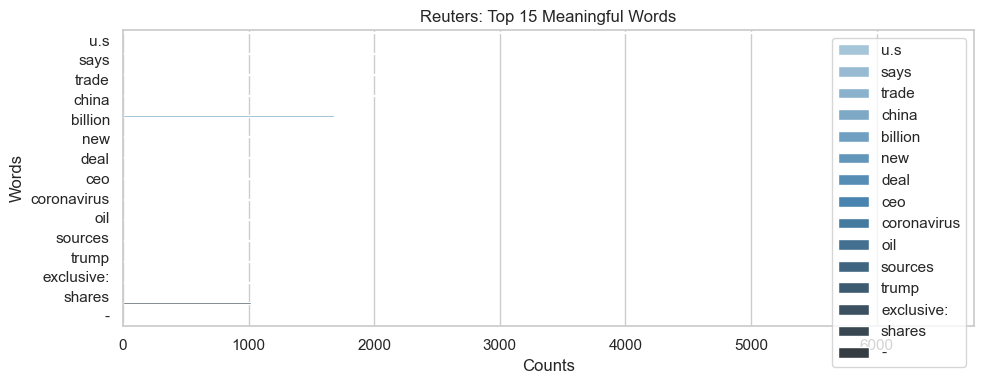

In [10]:
# Function to clean and process headlines for meaningful word frequencies
def process_and_plot(data, title, start=0, end=15, stopwords=None):
    stopwords = stop_words
    
    combined_string = ' '.join(data['Headlines'])  # Combine all headlines
    word_list = combined_string.split()  # Split into words
    word_list = [word.lower().strip(",.!?()[]") for word in word_list if word.lower() not in stopwords]
    
    # Calculate word frequencies
    word_count = Counter(word_list)
    
    # Sort words by frequency
    sorted_words = word_count.most_common()  # Sort by frequency
    top_words = sorted_words[start:end]  # Select words from the specified range
    
    # Create lists of words and their counts
    words = [word for word, count in top_words]
    counts = [count for word, count in top_words]
    
    # Plot the bar chart
    plt.figure(figsize=(10, 4))
    sns.barplot(x=counts, y=words,hue=words, palette="Blues_d", orient="h")
    plt.xlabel('Counts')
    plt.ylabel('Words')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot for each dataset excluding common stopwords
process_and_plot(guardian_data, 'Guardian: Top 15 Meaningful Words Frequency')
process_and_plot(cnbc_data, 'CNBC: Top 15 Meaningful Words Frequency')
process_and_plot(reuters_data, 'Reuters: Top 15 Meaningful Words')

Most of the words are meaningful, but who is `cramer` in the CNBC dataset? Turns out [Jim Cramer](https://en.wikipedia.org/wiki/Jim_Cramer) is the host of various financial programs in CNBC. We will prune him out from the CNBC dataset later.

### S&P 500 Dataset

In [11]:
ticker = "^GSPC"
start_date = "2017-12-01"
end_date = "2020-07-31"

data = yf.download(ticker, start=start_date, end=end_date, interval="1d")
data_hlcv = data[['High', 'Low', 'Close', 'Volume']]

[*********************100%***********************]  1 of 1 completed


#### Statistical Analysis

In [12]:
data_hlcv.describe()

Price,High,Low,Close,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC
count,669.000000,669.000000,669.000000,6.690000e+02
mean,2883.568308,2849.033738,2867.277964,3.965081e+09
std,198.117998,206.057495,202.285824,1.154337e+09
min,2300.729980,2191.860107,2237.399902,1.296530e+09
25%,2739.189941,2709.540039,2724.439941,3.300220e+09
50%,2856.669922,2825.389893,2843.489990,3.635780e+09
75%,2999.149902,2970.090088,2984.870117,4.156640e+09
max,3393.520020,3378.830078,3386.149902,9.053950e+09


The S&P 500 dataset from December 1, 2017, to July 31, 2020, contains **669** daily records with columns for `High`, `Low`, `Close`, and `Volume`, with **no missing values**. The average 'High', 'Low', and 'Close' prices are around 2883, 2849, and 2867, respectively, with standard deviations near 200 points, indicating moderate volatility. The 'Volume' data, averaging 3.97 billion shares, shows considerable variability, ranging from 1.3 billion to 9.05 billion, reflecting spikes in trading activity during certain market events.

To prepare for analysis, normalization or standardization may be beneficial to handle the scale differences, particularly between price and volume data. This initial overview confirms a relatively stable daily distribution, setting up further analysis on trends, volatility, and potential event impacts on S&P 500 performance.

#### Close Price over Time

/Users/kellygong/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kellygong/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


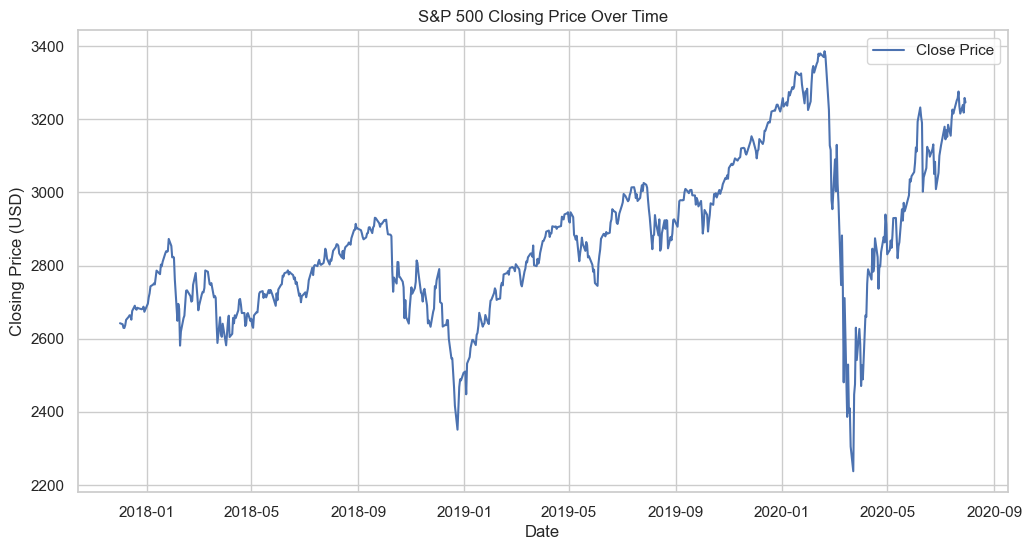

In [13]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=data_hlcv.index, y=data_hlcv['Close'].squeeze(), color="#4c72b0", label="Close Price")
plt.title("S&P 500 Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.show()

This is the stock price of the S&P 500 over min and max dates covered by the news headlines. Some noticeable features that are included in this graph is the large dip during early 2020 caused by covid. This will have an interesting impact on our model since the news did play a big role in the scare factor for COVID-19, but the fact that it was caused by a global epidemic may skew the embeddings of other words.  

## Data Preprocessing

Clean out `NaT` values in `Time` column of three datasets.

In [14]:
guardian_data.dropna(subset=['Time'], inplace=True)
cnbc_data.dropna(subset=['Time'], inplace=True)
reuters_data.dropna(subset=['Time'], inplace=True)

### Cleaning Text

Here we did our first cleaning by converting all characters to lower case, and remove extra spaces, quotation marks and other unwanted ones. We are also removing `Jim` `Cramer`, as well as his show `Mad Money` from the CNBC dataset.

In [15]:
def clean_headlines(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove special characters except hyphens and spaces
    text = re.sub(r"[^\w\s\-]", "", text)
    words = word_tokenize(text)

    cleaned_text = " ".join(words)
    return cleaned_text


guardian_data['Headlines'] = guardian_data['Headlines'].apply(clean_headlines)

cnbc_data['Headlines'] = cnbc_data['Headlines'].apply(clean_headlines)
cnbc_data['Description'] = cnbc_data['Description'].apply(clean_headlines)

reuters_data['Headlines'] = reuters_data['Headlines'].apply(clean_headlines)
reuters_data['Description'] = reuters_data['Description'].apply(clean_headlines)

def remove_jim(text):
    words_to_remove = ['jim', 'cramer', 'mad money']

    pattern = r'\b(' + '|'.join(words_to_remove) + r')\b'
    cleaned = re.sub(pattern, '', text, flags=re.IGNORECASE)

    cleaned = re.sub(r'\s+', ' ', cleaned).strip()
    return cleaned

cnbc_data['Headlines'] = cnbc_data['Headlines'].apply(remove_jim)
cnbc_data['Description'] = cnbc_data['Description'].apply(remove_jim)

cnbc_data.head()

,Headlines,Time,Description
0,a better way to invest in the covid-19 vaccine...,2020-07-17 19:51:00,host recommended buying four companies that ar...
1,cramers lightning round i would own teradyne,2020-07-17 19:33:00,host rings the lightning round bell which mean...
3,cramers week ahead big week for earnings even ...,2020-07-17 19:25:00,well pay more for the earnings of the non-covi...
4,iq capital ceo keith bliss says tech and healt...,2020-07-17 16:24:00,keith bliss iq capital ceo joins closing bell ...
5,wall street delivered the kind of pullback ive...,2020-07-16 19:36:00,look for the stocks of high-quality companies ...


### Add Prediction Target

Since our goal is to relate news outlets with S&P500, part of our project will be focusing on the trend prediction of future S&P 500 price change. Which we created a binary column `trend_up` which will be `True` if the price current trading date is lower than tomorrow's.

In [16]:
stock_data = data_hlcv.reset_index()[['Date', 'Close']]

# Flatten the column headers if they are multi-level
stock_data.columns = stock_data.columns.map(lambda x: x[1] if isinstance(x, tuple) else x)
stock_data.rename(columns={stock_data.columns[0]: 'Date', stock_data.columns[1]: 'Close'}, inplace=True)

stock_data['trend_up'] = stock_data['Close'].shift(-1) > stock_data['Close']
stock_data.head()

,Date,Close,trend_up
0,2017-12-01 00:00:00+00:00,2642.219971,False
1,2017-12-04 00:00:00+00:00,2639.439941,False
2,2017-12-05 00:00:00+00:00,2629.570068,False
3,2017-12-06 00:00:00+00:00,2629.270020,True
4,2017-12-07 00:00:00+00:00,2636.979980,True


We also want to make sure that the proportion `True` and `False` are balanced.

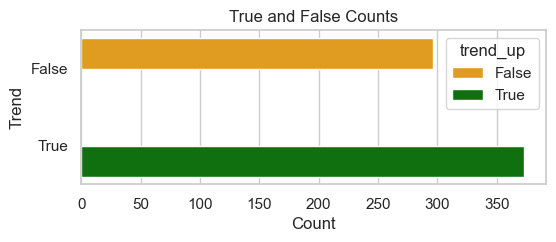

In [17]:
trend_counts = stock_data['trend_up'].value_counts()
colors = ["orange" if trend == False else "green" for trend in trend_counts.index]

plt.figure(figsize=(6, 2))
sns.barplot(
    y=trend_counts.index,
    hue=trend_counts.index,
    x=trend_counts.values,
    palette=["orange","green"],
    orient='h'
)
plt.title("True and False Counts")
plt.ylabel("Trend")
plt.xlabel("Count")
plt.yticks(ticks=[0, 1], labels=["False", "True"]) 
plt.show()

### Set Time Granularity

Though some of the datasets has timestamp with minute-wise precisions, we only want to research on a daily basis.

In [18]:
guardian_data['Date'] = pd.to_datetime(guardian_data['Time']).dt.date
cnbc_data['Date'] = pd.to_datetime(cnbc_data['Time']).dt.date
reuters_data['Date'] = pd.to_datetime(reuters_data['Time']).dt.date

guardian_data.drop(columns=['Time'],inplace=True)
cnbc_data.drop(columns=['Time'],inplace=True)
reuters_data.drop(columns=['Time'],inplace=True)

stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date

### Concatenate 3 New Datasets

For our first model, we will ignore temporal relationship by treating every news as an independent datapoint. We merged all datasets into one, along with the prediction target.

In [19]:
# Concatenate datasets with stock data
cnbc_merged = pd.merge(cnbc_data, stock_data, on='Date', how='inner')
cnbc_merged['Source'] = 'CNBC'
guardian_merged = pd.merge(guardian_data, stock_data, on='Date', how='inner')
guardian_merged['Source'] = 'Guardian'
reuters_merged = pd.merge(reuters_data, stock_data, on='Date', how='inner')
reuters_merged['Source'] = 'Reuters'

# Combine all datasets into one
first_model_data = pd.concat([cnbc_merged, guardian_merged, reuters_merged])

first_model_data.to_csv("dataset/first_model_data.csv", index=False) 
first_model_data.head()

,Headlines,Description,Date,Close,trend_up,Source
0,a better way to invest in the covid-19 vaccine...,host recommended buying four companies that ar...,2020-07-17,3224.729980,True,CNBC
1,cramers lightning round i would own teradyne,host rings the lightning round bell which mean...,2020-07-17,3224.729980,True,CNBC
2,cramers week ahead big week for earnings even ...,well pay more for the earnings of the non-covi...,2020-07-17,3224.729980,True,CNBC
3,iq capital ceo keith bliss says tech and healt...,keith bliss iq capital ceo joins closing bell ...,2020-07-17,3224.729980,True,CNBC
4,wall street delivered the kind of pullback ive...,look for the stocks of high-quality companies ...,2020-07-16,3215.570068,True,CNBC


### Word Tokenization

!!!!!!!!**Need further revision**!!!!!!!!!!!!

In [20]:
final_dataset = first_model_data.copy()
# Preprocess the text - clean the headlines
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)  # remove non-word characters
    text = re.sub(r'\s+', ' ', text)  # remove extra spaces
    return text.strip()

final_dataset['cleaned_headlines'] = final_dataset['Headlines'].apply(preprocess_text)

# Tokenize - Create a vocabulary (word to integer mapping)
all_words = ' '.join(final_dataset['cleaned_headlines']).split()
vocab = {word: idx + 1 for idx, word in enumerate(set(all_words))}  # map words to unique integers

# Tokenize the dataset - convert each word in a headline to its corresponding integer
def tokenize(text, vocab):
    return [vocab[word] for word in text.split() if word in vocab]

final_dataset['tokenized_headlines'] = final_dataset['cleaned_headlines'].apply(lambda x: tokenize(x, vocab))

final_dataset[['Headlines', 'tokenized_headlines']].head()

,Headlines,tokenized_headlines
0,a better way to invest in the covid-19 vaccine...,"[10677, 10343, 2039, 11664, 18303, 15930, 1507..."
1,cramers lightning round i would own teradyne,"[14598, 13247, 13443, 18602, 15724, 7052, 8476]"
2,cramers week ahead big week for earnings even ...,"[14598, 6504, 24165, 767, 6504, 4639, 4259, 19..."
3,iq capital ceo keith bliss says tech and healt...,"[1857, 14283, 22300, 17120, 18735, 8084, 16235..."
4,wall street delivered the kind of pullback ive...,"[2637, 19902, 22090, 15076, 14544, 15380, 1828..."


In [21]:
embedding_size = 50
embedding_matrix = {}

for word, idx in vocab.items():
    embedding_matrix[word] = np.random.randn(embedding_size)  # Random vector for each word

embedding_df = pd.DataFrame.from_dict(embedding_matrix, orient='index')
embedding_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
limitations,1.225478,0.461920,-0.281478,-0.286544,-0.032989,1.738201,-0.104638,1.344797,-0.219651,0.185847,...,-0.318969,-0.768547,-1.691410,1.058019,-0.323766,-0.464959,-1.539044,-0.538751,-1.383447,0.221354
walt,-0.892194,-0.935788,1.402287,0.204341,1.154635,0.338424,-0.017165,-0.590650,-1.180018,0.830119,...,-1.463615,3.003146,-0.405786,-2.352489,-0.135587,0.588856,-0.643507,-0.933257,0.898882,0.898332
zte,2.201095,-0.207456,-0.578566,-0.511329,-0.549410,-0.291844,2.045927,2.004559,-0.349664,0.177331,...,-0.853602,1.083100,-0.441647,0.782196,-0.268766,-2.212211,0.498096,0.935380,-0.286859,-0.432245
courting,-0.943069,1.423665,-0.672602,0.894431,1.056862,-1.820713,1.202395,-0.033057,-1.272297,0.401860,...,1.581941,-0.328258,-0.565775,0.600694,0.215084,0.964764,-2.057580,-1.542064,0.190193,-0.839631
lightsource,-1.843015,-0.465455,-0.771394,0.647296,0.226665,-2.498245,1.043375,-0.077350,0.562924,2.010849,...,0.240310,-0.564504,0.452174,-0.062110,0.307979,1.298843,0.486878,-2.159434,0.147814,-0.479902


## Base Models

### Classification Models

We are using logistic regression with TF-IDF features as our base model.

#### Individual Headline Model

For this model, we are treating every news are individual data points. This is guarantee to fail because there is way to little information contained in a single news title, and there will be too much noise.

In [22]:
data = first_model_data[['Headlines', 'trend_up']].copy()

vectorizer = TfidfVectorizer(max_features=300) 
X = vectorizer.fit_transform(data['Headlines']).toarray()
y = data['trend_up']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LogisticRegression(random_state=42, max_iter=1500)
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Display results
print("Test Accuracy:", test_accuracy)
print("Train Accuracy:", train_accuracy)
print("Report on test dataset:")
pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True)).transpose()

Test Accuracy: 0.5483973341796256
Train Accuracy: 0.56725378186819
Report on test dataset:


,precision,recall,f1-score,support
False,0.469713,0.104938,0.171551,4212.000000
True,0.557096,0.904789,0.689595,5241.000000
accuracy,0.548397,0.548397,0.548397,0.548397
macro avg,0.513404,0.504864,0.430573,9453.000000
weighted avg,0.518160,0.548397,0.458768,9453.000000


#### Joint Headline Model

By joining all headlines of the same day in to one sentence, we hope that TF-IDF could capture more information than our previous model.

In [23]:
grouped_dataset = first_model_data.groupby('Date').agg(
    Headlines=('Headlines', ' '.join), 
    trend_up=('trend_up', 'first') 
).reset_index()

grouped_dataset.head()

,Date,Headlines,trend_up
0,2017-12-18,france saves marquis de sades 120 days of sodo...,False
1,2017-12-19,house prices to fall in london and south-east ...,False
2,2017-12-20,hedge funds fail to stop billion-dollar brain ...,True
3,2017-12-21,guardian brexit watch brexit helped push down ...,False
4,2017-12-22,says owning too many stocks and too little cas...,False


In [24]:
data = grouped_dataset[['Headlines', 'trend_up']].copy()

vectorizer = TfidfVectorizer(max_features=200)
X = vectorizer.fit_transform(data['Headlines']).toarray()
y = data['trend_up']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LogisticRegression(random_state=42, max_iter=1500)
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Display results
print("Test Accuracy:", test_accuracy)
print("Train Accuracy:", train_accuracy)
print("Report on test dataset:")
pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True)).transpose()

Test Accuracy: 0.5923076923076923
Train Accuracy: 0.6460348162475822
Report on test dataset:


,precision,recall,f1-score,support
False,0.526316,0.185185,0.273973,54.000000
True,0.603604,0.881579,0.716578,76.000000
accuracy,0.592308,0.592308,0.592308,0.592308
macro avg,0.564960,0.533382,0.495275,130.000000
weighted avg,0.571499,0.592308,0.532726,130.000000


We also experimented in the amount of features TF-IDF should have in order to have the best performance.

/Users/kellygong/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kellygong/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kellygong/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/kellygong/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with 

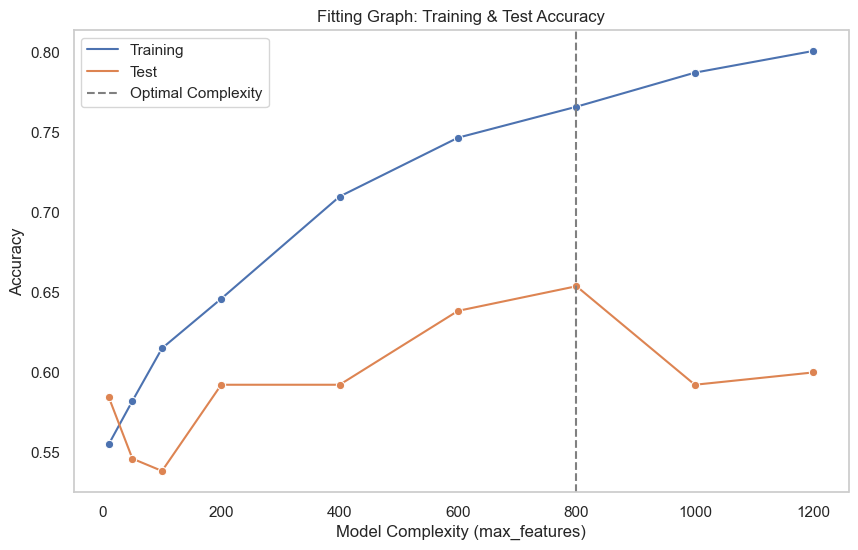

In [25]:
complexities = [10, 50, 100, 200, 400, 600, 800, 1000, 1200]

# Lists to store accuracies
train_accuracies = []
test_accuracies = []

for max_features in complexities:
    vectorizer = TfidfVectorizer(max_features=max_features)
    X = vectorizer.fit_transform(data['Headlines']).toarray()
    y = data['trend_up']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = LogisticRegression(random_state=42, max_iter=1500)
    model.fit(X_train, y_train)
    
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)


plot_data = pd.DataFrame({
    'Complexity': complexities * 2,
    'Accuracy': train_accuracies + test_accuracies,
    'Type': ['Training'] * len(complexities) + ['Test'] * len(complexities)
})

plt.figure(figsize=(10, 6))
sns.lineplot(data=plot_data, x='Complexity', y='Accuracy', hue='Type', marker='o')
plt.axvline(x=complexities[np.argmax(test_accuracies)], linestyle='--', color='gray', label="Optimal Complexity")
plt.title("Fitting Graph: Training & Test Accuracy")
plt.xlabel("Model Complexity (max_features)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

As expected, we do not need to high complexity for TF-IDF, as increasing it will overfit our training dataset. A complexity around 800 yields the best result on the test set with accuracy about 65%.

### LSTM

In [26]:
# !pip install tensorflow

In [27]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout
from sklearn.ensemble import RandomForestClassifier

2024-11-27 14:57:48.687055: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
lstm_df = final_dataset[['Date', 'cleaned_headlines', 'tokenized_headlines', 'trend_up']]
lstm_df

,Date,cleaned_headlines,tokenized_headlines,trend_up
0,2020-07-17,a better way to invest in the covid 19 vaccine...,"[10677, 10343, 2039, 11664, 18303, 15930, 1507...",True
1,2020-07-17,cramers lightning round i would own teradyne,"[14598, 13247, 13443, 18602, 15724, 7052, 8476]",True
2,2020-07-17,cramers week ahead big week for earnings even ...,"[14598, 6504, 24165, 767, 6504, 4639, 4259, 19...",True
3,2020-07-17,iq capital ceo keith bliss says tech and healt...,"[1857, 14283, 22300, 17120, 18735, 8084, 16235...",True
4,2020-07-16,wall street delivered the kind of pullback ive...,"[2637, 19902, 22090, 15076, 14544, 15380, 1828...",True
...,...,...,...,...
30142,2018-03-20,malaysia says never hired british data firm at...,"[18327, 8084, 23396, 16666, 8874, 14605, 23414...",False
30143,2018-03-20,prosecutors search volkswagen headquarters in ...,"[2120, 11013, 18220, 18149, 15930, 22772, 1890...",False
30144,2018-03-20,mcdonalds sets greenhouse gas reduction targets,"[23340, 15771, 4588, 21558, 14966, 20971]",False
30145,2018-03-20,pratt whitney to deliver spare a320neo engines...,"[22763, 17003, 11664, 8885, 7943, 16075, 12771...",False


In [29]:
# Convert boolean target to integer
lstm_df['trend_up'] = lstm_df['trend_up'].astype(int)

# Get tokenized headlines as input (no need for additional tokenization)
X = lstm_df['tokenized_headlines'].values

# Pad sequences to ensure uniform length
max_sequence_length = max([len(seq) for seq in X])  # Get the max sequence length
X_pad = pad_sequences(X, maxlen=max_sequence_length)

# Target variable
y = lstm_df['trend_up'].values

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

/var/folders/t_/7xrkzl6x7qx_hqbfd9044jzw0000gn/T/ipykernel_18869/1510327176.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstm_df['trend_up'] = lstm_df['trend_up'].astype(int)


In [31]:
### Step 1: Train LSTM Model
# Define model parameters
vocab_size = len(np.unique(np.hstack(X_pad))) + 1  # Vocabulary size
embedding_dim = 100  # Embedding dimension
max_sequence_length = X_pad.shape[1]  # Length of input sequences

# Build the LSTM model
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    LSTM(128),
    Dropout(0.5),  # Regularization
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile and train the LSTM
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Get LSTM predictions
lstm_train_preds = lstm_model.predict(X_train).flatten()
lstm_test_preds = lstm_model.predict(X_test).flatten()

# Convert the predictions to binary values (0 or 1)
lstm_train_preds_binary = (lstm_train_preds > 0.5).astype(int)
lstm_test_preds_binary = (lstm_test_preds > 0.5).astype(int)

# Metrics
train_accuracy = accuracy_score(y_train, lstm_train_preds_binary)
test_accuracy = accuracy_score(y_test, lstm_test_preds_binary)

# Display results
print("Test Accuracy:", test_accuracy)
print("Train Accuracy:", train_accuracy)



Epoch 1/10


/Users/kellygong/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


591/591 ━━━━━━━━━━━━━━━━━━━━ 32s 49ms/step - accuracy: 0.5641 - loss: 0.6866 - val_accuracy: 0.5561 - val_loss: 0.6865
Epoch 2/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 30s 51ms/step - accuracy: 0.6147 - loss: 0.6542 - val_accuracy: 0.5409 - val_loss: 0.6978
Epoch 3/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 29s 49ms/step - accuracy: 0.7152 - loss: 0.5553 - val_accuracy: 0.5369 - val_loss: 0.7796
Epoch 4/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 29s 49ms/step - accuracy: 0.7998 - loss: 0.4278 - val_accuracy: 0.5325 - val_loss: 0.8725
Epoch 5/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 29s 49ms/step - accuracy: 0.8525 - loss: 0.3204 - val_accuracy: 0.5303 - val_loss: 1.1417
Epoch 6/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 29s 49ms/step - accuracy: 0.8888 - loss: 0.2404 - val_accuracy: 0.5286 - val_loss: 1.5023
Epoch 7/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 29s 49ms/step - accuracy: 0.9119 - loss: 0.1880 - val_accuracy: 0.5275 - val_loss: 1.8351
Epoch 8/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 29s 49ms/step - accuracy: 0.9338 - loss: 0.1412 - val_accurac

#### Add Random Forest

In [32]:
### Step 2: Train Random Forest with TF-IDF Features
# Convert sequences to strings for TF-IDF
tfidf = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
rf_X_train = tfidf.fit_transform([' '.join(map(str, seq)) for seq in X_train])
rf_X_test = tfidf.transform([' '.join(map(str, seq)) for seq in X_test])

# Train Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(rf_X_train, y_train)

# Get Random Forest predictions
rf_train_preds = rf_model.predict_proba(rf_X_train)[:, 1]  # Use probabilities for meta-classifier
rf_test_preds = rf_model.predict_proba(rf_X_test)[:, 1]    # Use probabilities for meta-classifier


In [33]:
### Step 3: Meta-Classifier
# Combine LSTM and RF predictions as features
meta_X_train = np.stack((lstm_train_preds, rf_train_preds), axis=1)
meta_X_test = np.stack((lstm_test_preds, rf_test_preds), axis=1)

# Train logistic regression as a meta-classifier
meta_clf = LogisticRegression()
meta_clf.fit(meta_X_train, y_train)

# Get meta-classifier predictions
meta_test_preds = meta_clf.predict(meta_X_test)

In [34]:
### Step 4: Evaluate Models
# Evaluate individual models
lstm_accuracy = accuracy_score(y_test, (lstm_test_preds > 0.5).astype(int))
rf_accuracy = accuracy_score(y_test, (rf_test_preds > 0.5).astype(int))

# Evaluate meta-classifier
meta_accuracy = accuracy_score(y_test, meta_test_preds)

print(f"LSTM Test Accuracy: {lstm_accuracy:.4f}")
print(f"Random Forest Test Accuracy: {rf_accuracy:.4f}")
print(f"Meta-Classifier Test Accuracy: {meta_accuracy:.4f}")

LSTM Test Accuracy: 0.5228
Random Forest Test Accuracy: 0.5460
Meta-Classifier Test Accuracy: 0.5372


### XGBoost

In [35]:
import xgboost as xgb

# Data Preparation
data = final_dataset[['cleaned_headlines', 'trend_up']]

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=200)
X = vectorizer.fit_transform(data['cleaned_headlines']).toarray()
y = data['trend_up']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:

# XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    random_state=42,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    use_label_encoder=False,  # Disable the warning for label encoding
    eval_metric="logloss"    # Required for classification tasks in recent versions
)

xgb_model.fit(X_train, y_train)

# Predictions
y_pred_test = xgb_model.predict(X_test)
y_pred_train = xgb_model.predict(X_train)

# Metrics
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Display results
print("Test Accuracy:", test_accuracy)
print("Train Accuracy:", train_accuracy)
print("Report on test dataset:")
print(pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True)).transpose())


/Users/kellygong/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:21:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 0.5544271659790543
Train Accuracy: 0.5926161007087697
Report on test dataset:
              precision    recall  f1-score      support
False          0.500000  0.068851  0.121035  4212.000000
True           0.557985  0.944667  0.701573  5241.000000
accuracy       0.554427  0.554427  0.554427     0.554427
macro avg      0.528992  0.506759  0.411304  9453.000000
weighted avg   0.532148  0.554427  0.442901  9453.000000


#### Fine tune using GridSearch

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import StratifiedKFold

# # Define your grid search hyperparameter space
# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'n_estimators': [100, 200, 500],
#     'subsample': [0.7, 0.8, 1.0],
#     'colsample_bytree': [0.7, 0.8, 1.0],
#     'gamma': [0, 0.1, 0.2],
#     'reg_alpha': [0, 0.1],
#     'reg_lambda': [0, 0.1]
# }

# # Define the model
# xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")

# # Use StratifiedKFold to handle imbalanced classes
# stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# # Perform GridSearchCV with 3-fold cross-validation
# grid_search = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     scoring='accuracy',
#     cv=stratified_cv,
#     verbose=1,
#     n_jobs=-1
# )

# # Fit the model
# grid_search.fit(X_train, y_train)

# # Get best parameters and evaluate
# best_model = grid_search.best_estimator_
# y_pred_test = best_model.predict(X_test)

# print("Best Parameters:", grid_search.best_params_)
# print("Best Cross-Validation Accuracy:", grid_search.best_score_)
# print("Test Accuracy:", accuracy_score(y_test, y_pred_test))

# # Classification report
# print(classification_report(y_test, y_pred_test))


Fitting 3 folds for each of 3888 candidates, totalling 11664 fits


/Users/kellygong/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/kellygong/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/kellygong/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/kellygong/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/kellygong/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWar

KeyboardInterrupt: 